

In this notebook i build first Generative Adversioal neural network (GAN)


---
---

Goal of this network generate handwritten digit (0-9)
- I am using MNIST dataset
- And framework i used PyTorch 🔥




---

---


In [13]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # This is our N dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # is mean never print random output!


# this is a visulize function that help print image GAN create !
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Generator G

In [14]:
# Generator One layer block

def get_generator_block(input_dim, output_dim):

    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

In [15]:
# Generator Class

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),


            nn.Linear(hidden_dim*8,im_dim),
            nn.Sigmoid()

        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)

    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

## Random Noise Z

In [16]:
# this function create random noise ! this is ess

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''


    return torch.randn((n_samples,z_dim),device=device)


## Discriminator D






In [17]:
# This is a Discriminator one layer block

def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation
          followed by an nn.LeakyReLU activation with negative slope of 0.2

    '''
    return nn.Sequential(

        nn.Linear(input_dim,output_dim),
        nn.LeakyReLU(0.2,inplace=True)

    )

In [18]:
# Discriminator network !

class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),

            nn.Linear(hidden_dim,1),

        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)

    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

# Training 🤖 ➰
Now put it all together! Train two network **{GD}**
First, you will set your parameters:
  *   **criterion:** the loss function
  *   **n_epochs:** the number of times you iterate through the entire dataset when training
  *   **z_dim:** the dimension of the noise vector
  *   **display_step:** how often to display/visualize the images
  *   **batch_size:** the number of images per forward/backward pass
  *   **lr:** the learning rate
  *   **device:** the device type, here using a **GPU** (which runs CUDA), not CPU

Next, you will load the MNIST dataset as tensors using a dataloader.



In [19]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cuda'

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)


Now, it's time ⏲ initialize  **generator, discriminator, and optimizers.**

---


In [20]:
# 1st inltialize model and move GPU fast computation
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

# 2nd intialize optimizer
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Before train **GAN** need a function that calculate **loss** Generator **G** ... Discriminator **D**

In [21]:
# Generator loss ** The main takeway this - Return loss the discriminator given input
# it's mean Discriminator take input , what Generator create and classfiy how real or fake is.


def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare
               the discriminator's predictions to the ground truth reality of the images
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''

    # START CODE HERE

    # 1. Create noise vectors and generate a batch (num_images) of fake images.And pass the device argument.
    noise = get_noise(num_images,z_dim,device=device)
    fake_image = gen(noise)
    # 2. Get the discriminator's prediction of the fake image and calculate the loss. Don't forget to detach the generator!
    disc_pred = disc(fake_image.detach())

    # Calculate the loss
    fake_loss = criterion(disc_pred,torch.zeros_like(disc_pred))

    # Get the discriminator's prediction of the real image and calculate the loss.
    real_pred = disc(real)
    real_loss = criterion(real_pred,torch.ones_like(real_pred))

    # Calculate the discriminator's loss by averaging the real and fake loss and set it to disc_loss.
    disc_loss = (fake_loss + real_loss)/2

    # END CODE HERE
    return disc_loss

In [22]:

# Generator loss
# The main goal is this function -

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare
               the discriminator's predictions to the ground truth reality of the images
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce,
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''

    # START CODE HERE

    # 1. Create noise vectors and generate a batch of fake images.
    fake_noise = get_noise(num_images,z_dim,device=device)
    fake_image = gen(fake_noise)

    # 2. Get the discriminator's prediction of the fake image.
    fake_pred = disc(fake_image)

    # 3.  Calculate the generator's loss.
    gen_loss = criterion(fake_pred,torch.ones_like(fake_pred))
    # END CODE HERE
    return gen_loss

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 4.052449818134306, discriminator loss: 0.07146432578936218


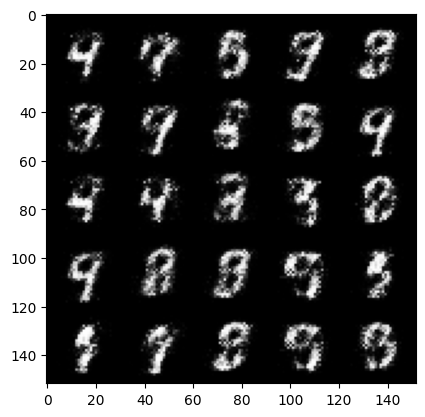

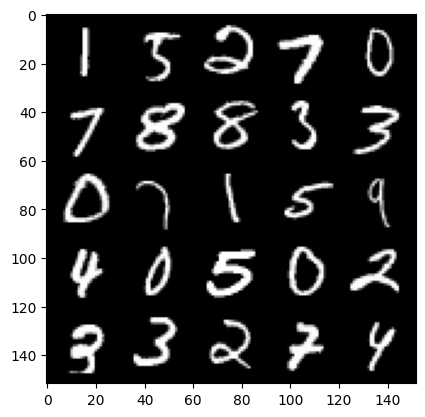

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
# OPTIONAL PART
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True
gen_loss = False
error = False



for epoch in range(n_epochs):

    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        # Update discriminator
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        # Update generator

        # Zero gradient
        gen.zero_grad()

        # Calculate the generator loss, assigning it to gen_loss
        gen_loss = get_gen_loss(gen,disc,criterion,cur_batch_size,z_dim,device)

        # Update Graident
        gen_loss.backward()

        # Update optimizer
        gen_opt.step()
        #### END CODE HERE ####

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
